# Book2Comic

Example notebook for checking all available features for the tool.

Developed by Miguel Ángel Dávila Romero and Tomás Alcántara Carrasco.

## Environment setup

Before running everything, make sure you are connected to a **GPU environment**.

After that, execute the following cells for installing requirements and importing libraries.

### Install requirements

In [ ]:
! pip install booknlp
! python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 36.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


### Import libraries

In [ ]:
from IPython.display import Image
import IPython.display as display
import os
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.modules.batchnorm import BatchNorm2d
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
from PIL import Image, ImageOps, ImageDraw, ImageFont
import numpy as np
from math import ceil
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import torch.optim as optim
from booknlp.booknlp import BookNLP
import base64
import json
import spacy
import requests
import io
import re
import pandas as pd
from collections import Counter

using device cuda


## Utils for execution

### Face detection utils

In [ ]:
# External Libraries



"""
###########################################################
# COMMON PARAMETERS
###########################################################
"""

# Device Parameters
run_gpu             = False
device              = "cuda" if run_gpu else "cpu"

# Train Parameters
weight_decay        = 0.0005

"""
###########################################################
# DETECTOR PARAMETERS
###########################################################
"""
# Training Parameters
rf_bs               = 20

# Loss Calculation Metrics
pos_iou             = 0.5
neg_iou             = 0.3
ohem_ratio          = 3
lambda1             = 2
variances           = [0.2, 0.1]


class Backbone(torch.nn.Module):
    def __init__(self, backbone="resnet50"):
        super(Backbone, self).__init__()

        if backbone == "resnet50" or backbone == "resnet152":
            if backbone == "resnet50":
                backbone = models.resnet50(pretrained=True)
            elif backbone == "resnet152":
                backbone = models.resnet152(pretrained=True)
            self.in_sizes = [256, 512, 1024, 2048]
            self.init_layer = nn.Sequential(
                backbone.conv1, backbone.bn1, backbone.relu, backbone.maxpool
            )
            self.layer1 = backbone.layer1
            self.layer2 = backbone.layer2
            self.layer3 = backbone.layer3
            self.layer4 = backbone.layer4

        elif backbone == "mobilenetv2":
            backbone = models.mobilenet_v2(pretrained=True)
            self.in_sizes = [24, 32, 96, 160]
            self.init_layer = backbone.features[0]
            self.layer1 = backbone.features[1:4]
            self.layer2 = backbone.features[4:7]
            self.layer3 = backbone.features[7:14]
            self.layer4 = backbone.features[14:19] # may be 18 also

    def forward(self, x):
        c2 = self.layer1(self.init_layer(x))
        c3 = self.layer2(c2)
        c4 = self.layer3(c3)
        c5 = self.layer4(c4)
        return [c2, c3, c4, c5]

class ConvBnRelu(torch.nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        padding=0,
        stride=1,
        dilation=1,
        groups=1,
        bias=False,
        momentum=0.1,
        eps=1e-5,
        leaky=0,
        ):
        super(ConvBnRelu, self).__init__()

        self.conv = nn.Conv2d(
            in_channels, out_channels, kernel_size,
            stride=stride, dilation=dilation,padding=padding,
            groups=groups, bias=bias
            )
        self.bn = BatchNorm2d(out_channels,eps=eps,momentum=momentum)

        if leaky == -1:
            self.activ = None
        elif leaky == 0:
            self.activ = nn.ReLU()
        else:
            self.activ = nn.LeakyReLU(negative_slope=leaky)


    def forward(self, x):
        x_val = self.bn(self.conv(x))
        if self.activ != None:
            return self.activ(x_val)
        return x_val

class ConvBnRelu(torch.nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        padding=0,
        stride=1,
        dilation=1,
        groups=1,
        bias=False,
        momentum=0.1,
        eps=1e-5,
        leaky=0,
        ):
        super(ConvBnRelu, self).__init__()

        self.conv = nn.Conv2d(
            in_channels, out_channels, kernel_size,
            stride=stride, dilation=dilation,padding=padding,
            groups=groups, bias=bias
            )
        self.bn = BatchNorm2d(out_channels,eps=eps,momentum=momentum)

        if leaky == -1:
            self.activ = None
        elif leaky == 0:
            self.activ = nn.ReLU()
        else:
            self.activ = nn.LeakyReLU(negative_slope=leaky)


    def forward(self, x):
        x_val = self.bn(self.conv(x))
        if self.activ != None:
            return self.activ(x_val)
        return x_val

class SSH(torch.nn.Module):
    def __init__(self, in_size=256, out_size=256):
        super(SSH, self).__init__()
        out_size4 = in_size//4; out_size2 = in_size//2
        self.conv128 = ConvBnRelu(in_size, out_size2, 3, bias=False, padding=1, leaky=-1)
        self.conv64_1_1 = ConvBnRelu(in_size, out_size4, 3, bias=False, padding=1)
        self.conv64_1_2 = ConvBnRelu(out_size4, out_size4, 3, bias=False, padding=1, leaky=-1)
        self.conv64_2_1 = ConvBnRelu(out_size4, out_size4, 3, bias=False, padding=1)
        self.conv64_2_2 = ConvBnRelu(out_size4, out_size4, 3, bias=False, padding=1, leaky=-1)
        self.activ = nn.ReLU()

    def forward(self, x):
        o1 = self.conv128(x)
        o2_1 = self.conv64_1_1(x)
        o2_2 = self.conv64_1_2(o2_1)
        o3_1 = self.conv64_2_1(o2_1)
        o3_2 = self.conv64_2_2(o3_1)
        return self.activ(torch.cat([o1, o2_2, o3_2], dim=1))

class ContextModule(torch.nn.Module):
    def __init__(self, in_size=256, out_size=256):
        super(ContextModule, self).__init__()
        self.ssh_list = nn.ModuleList()
        for i in range(5):
            self.ssh_list.append(SSH(in_size=in_size, out_size=out_size))

    def forward(self, xs):
        outs = []
        for i in range(len(xs)):
            outs.append(self.ssh_list[i](xs[i]))
        return outs

class FeaturePyramid(torch.nn.Module):
    def __init__(self, in_sizes=[256, 512, 1024, 2048], out_size=256):
        super(FeaturePyramid, self).__init__()

        self.lateral_ins = nn.ModuleList()
        # getting layers for lateral connections
        for ins in in_sizes:
            self.lateral_ins.append(ConvBnRelu(ins, out_size, 1, bias=False))

        self.lateral_ins.append(
            ConvBnRelu(in_sizes[-1], out_size, 3, stride=2, padding=1, bias=False)
        )
        self.extra = True
        self.lateral_outs = nn.ModuleList()
        for _ in range(len(self.lateral_ins)-1):
            self.lateral_outs.append(
                ConvBnRelu(out_size, out_size, 3, padding=1, bias=False)
            )

    def forward(self, xs):
        outs = []
        outs.append(self.lateral_ins[-1](xs[-1])) # P6

        inter_outs = []
        for idx in range(4):
            inter_outs.append(self.lateral_ins[idx](xs[idx]))
        outs.append(inter_outs[-1]) # P5

        for idx in range(3, 0, -1):
            conn = F.interpolate(
                inter_outs[idx],
                size=[inter_outs[idx-1].size(2), inter_outs[idx-1].size(3)],
                mode="nearest"
            )
            outs.append(self.lateral_outs[idx-1](conn + inter_outs[idx-1])) # P4, P3, P2

        outs.reverse()
        return outs

class HeadGetter(torch.nn.Module):
    def __init__(self, input_dims, task_len, lateral_conn=5, num_anchors=3):
        super(HeadGetter, self).__init__()
        self.layers = nn.ModuleList()
        self.task_len = task_len
        for _ in range(lateral_conn):
            self.layers.append(
                nn.Conv2d(input_dims, num_anchors*task_len, 1, bias=True)
            )

    def forward(self, xs):
        proposals = []
        T = self.task_len
        for i, x in enumerate(xs):
            proposal = self.layers[i](x)
            N, C, H, W = proposal.size()
            A = int(W*H*(C/T))
            proposal = proposal.permute(0,2,3,1).contiguous()
            proposal = proposal.view(proposal.shape[0], -1, T)
            proposals.append(proposal)
        return torch.cat(proposals, dim=1)

def read_image(img_path, boxes, augment=True, resize_len=[640, 640]):
    img = Image.open(img_path).convert('RGB')
    box = np.array(boxes).copy() if boxes is not None else None

    if augment:
        img, box = crop(img, box)
        img = distort_color(img)
        img, box = horizontal_flip(img, box)
        img, box = resize(img, box, resize_len)

    elif resize_len[0] > 0 and resize_len[0] == resize_len[1]:
        img = squaritize(img)
        img, box = resize(img, box, resize_len)
    else:
        img, box = resize(img, box, resize_len)

    img = normalize(transforms.ToTensor()(img))
    box = torch.Tensor(box) if box is not None else None
    if run_gpu:
        img = img.cuda(); box = box.cuda() if box is not None else None

    if box is not None:
        return img, box
    else:
        return img


def normalize(img, means=[0.485, 0.456, 0.406], stds=[0.229, 0.224, 0.225]):
    return TF.normalize(img, mean=means, std=stds)

"""
mode -> 0 : add right and bottom size
mode -> 1 : add left and upper side
mode -> 2 : center the image
"""
def squaritize(img, mode=0):
    W, H = img.size
    if W == H:
        return img
    max_len = max(W, H)
    delta_w = max_len - W; delta_h = max_len - H
    if mode == 0:
        padding = (0, 0, delta_w, delta_h)
    elif mode == 1:
        padding = (delta_w, delta_h, 0, 0)
    else:
        padding = (delta_w//2, delta_h//2, delta_w-(delta_w//2), delta_h-(delta_h//2))
    return ImageOps.expand(img, padding)


def distort_color(img):
    if np.random.rand() > 0.5:
        br_strength = np.random.randint(4, 21) / 10
        img = TF.adjust_brightness(img, br_strength) # 0.4 - 2.0 range
    if np.random.rand() > 0.5:
        con_strength = np.random.randint(4, 31) / 10
        img = TF.adjust_contrast(img, con_strength) # 0.4 - 3.0 range
    if np.random.rand() > 0.5:
        hue_strength = np.random.randint(-5, 5) / 10
        img = TF.adjust_hue(img, hue_strength) # -0.4 - 0.4 range
    if np.random.rand() > 0.5:
        sat_strength = np.random.randint(-1, 20) / 10
        img = TF.adjust_saturation(img, sat_strength) # 0.0 - 2.0 range
    return img


def horizontal_flip(img, box):
    if np.random.rand() > 0.5:
        W, H = img.size
        img = TF.hflip(img)
        if box is not None:
            box[:,0:4:2] = W - box[:,0:4:2]
            box[np.where(box > W)] = -1
            temp = box[:,0].copy()
            box[:,0] = box[:,2]
            box[:,2] = temp
    return img, box


def resize(img, box, resize_len):
    W, H = img.size
    resize_len[0] = W if resize_len[0] < 0 else resize_len[0]
    resize_len[1] = H if resize_len[1] < 0 else resize_len[1]
    w_ratio = resize_len[0]/W; h_ratio = resize_len[1]/H

    img = TF.resize(img, (resize_len[1], resize_len[0]))
    if box is not None:
        box[:,0:4:2] *= w_ratio
        box[:,1:4:2] *= h_ratio
    return img, box


def crop(img, box):
    W, H = img.size
    min_len = min(W, H)
    crop_ratios = [0.3, 0.45, 0.6, 0.8, 1.0]

    while True: # at least center of one face will be in cropped image
        crop_ratio = np.random.choice(crop_ratios)
        side_len = min_len * crop_ratio - 1
        w_start = np.random.randint(0, max(1, W - side_len + 1))
        h_start = np.random.randint(0, max(1, H - side_len + 1))

        centers = box[:,2:4] - box[:,0:2]
        in_bound = (w_start <= centers[:,0])*(centers[:,0] <= w_start + side_len)
        in_bound *= (h_start <= centers[:,1])*(centers[:,1] <= h_start + side_len)
        in_bound = np.where(in_bound == True)[0].flatten()

        if len(in_bound) > 0:
            break

    box = box[in_bound, :]

    img = TF.crop(img, h_start, w_start, side_len, side_len)
    if box is not None:
        box[:,0:4:2] -= w_start
        box[:,1:4:2] -= h_start
        box[:,0:4] = np.minimum(side_len, np.maximum(0, box[:,0:4]))
        corr_x = np.where(box[:,2]-box[:,0] > 0)
        corr_y = np.where(box[:,3]-box[:,1] > 0)
        visible_faces = np.intersect1d(corr_x, corr_y)
        box = box[visible_faces,:]
    return img, box

def get_PIL_image(img_tensor):
    img = img_tensor.to("cpu")
    means = torch.Tensor([[[0.485]], [[0.456]], [[0.406]]])
    stds = torch.Tensor([[[0.229]], [[0.224]], [[0.225]]])
    return transforms.ToPILImage()(img * stds + means)

class ICF_Data:

    def __init__(self, icf_path, labels_path, batch_size=1, augment=True, img_sizes=[640, 640]):

        self.imgs_path = []
        self.boxes  = {}
        self.augment = augment
        self.img_sizes = img_sizes
        self.batch_size = batch_size

        f = open(labels_path,'r')
        lines = f.readlines()
        f.close()

        for line in lines:
            line = line.rstrip().split(',')
            labels = [float(x) for x in line[1:]]
            person_annot = np.zeros(4)
            person_annot[0:4] = labels[0:4]
            if icf_path + line[0] not in self.boxes:
                self.boxes[icf_path + line[0]] = []
            self.boxes[icf_path + line[0]].append(person_annot)

        for k in self.boxes.keys():
            self.boxes[k] = np.array(self.boxes[k])

        self.imgs_path = [*self.boxes.keys()]

        if self.augment:
            self.state = np.random.permutation(len(self.imgs_path))
        else:
            self.state = np.arange(len(self.imgs_path))


    def forward(self, restart=False):
        if restart:
            if self.augment:
                self.state = np.random.permutation(len(self.imgs_path))
            else:
                self.state = np.arange(len(self.imgs_path))

        if self.state is None or len(self.state) < self.batch_size:
            return None, None
        else:
            indices = self.state[0:self.batch_size].copy()
            self.state = None if len(self.state)  == self.batch_size else self.state[self.batch_size:]

            if self.batch_size > 1 and self.img_sizes[0] > 0:
                x = torch.zeros(self.batch_size, 3, self.img_sizes[1], self.img_sizes[0]).to(device)

            y = []
            for i, idx in enumerate(indices):
                img_path = self.imgs_path[idx]
                boxes = self.boxes[img_path]
                img, box = read_image(img_path, boxes, self.augment, self.img_sizes)
                y.append(box)
                if self.batch_size == 1:
                    return img.unsqueeze(0), y
                else:
                    x[i,:,:,:] = img

            return x, y

class Mixed_Data:

    def __init__(self, wf_path, wf_labels_path, icf_path, icf_labels_path, batch_size=1, augment=True, img_sizes=[640, 640]):

        self.augment = augment
        self.img_sizes = img_sizes
        self.batch_size = batch_size

        self.boxes = {}; self.imgs_path = []
        icf_paths, icf_boxes = self.get_icf_data(icf_path, icf_labels_path)
        self.boxes.update(icf_boxes);  self.imgs_path.extend(icf_paths)
        wf_paths, wf_boxes = self.get_wf_data(wf_path, wf_labels_path)
        self.boxes.update(wf_boxes); self.imgs_path.extend(wf_paths)

        if self.augment:
            self.state = np.random.permutation(len(self.imgs_path))
        else:
            self.state = np.arange(len(self.imgs_path))


    def get_wf_data(self, wf_path, wf_labels_path):
        f = open(wf_labels_path,'r')
        lines = f.readlines()
        f.close()

        boxes = {}; imgs_path = []
        img_boxes = []; last_path = None

        for line in lines:
            line = line.rstrip()
            if line.startswith('#'):
                if last_path is not None:
                    boxes[last_path] = np.array(img_boxes)
                    img_boxes = []
                path = line[2:]
                path = wf_path + 'images/' + path
                last_path = path
                imgs_path.append(path)
            else:
                line = line.split(' ')
                labels = [float(x) for x in line]
                person_annot = np.zeros(4)
                person_annot[0:4] = labels[0:4]
                person_annot[2:4] += person_annot[0:2]
                img_boxes.append(person_annot)

        boxes[last_path] = np.array(img_boxes)
        return imgs_path, boxes

    def get_icf_data(self, icf_path, icf_labels_path):
        f = open(icf_labels_path,'r')
        lines = f.readlines()
        f.close()
        boxes = {}
        for line in lines:
            line = line.rstrip().split(',')
            person_annot = [float(x) for x in line[1:5]]
            if icf_path + line[0] not in self.boxes:
                boxes[icf_path + line[0]] = []
            boxes[icf_path + line[0]].append(person_annot)

        imgs_path = [*boxes.keys()]
        return imgs_path, boxes


    def forward(self, restart=False):
        if restart:
            if self.augment:
                self.state = np.random.permutation(len(self.imgs_path))
            else:
                self.state = np.arange(len(self.imgs_path))

        if self.state is None or len(self.state) < self.batch_size:
            return None, None
        else:
            indices = self.state[0:self.batch_size].copy()
            self.state = None if len(self.state)  == self.batch_size else self.state[self.batch_size:]

            if self.batch_size > 1 and self.img_sizes[0] > 0:
                x = torch.zeros(self.batch_size, 3, self.img_sizes[1], self.img_sizes[0]).to(device)

            y = []
            for i, idx in enumerate(indices):
                img_path = self.imgs_path[idx]
                boxes = self.boxes[img_path]
                img, box = read_image(img_path, boxes, self.augment, self.img_sizes)
                y.append(box)
                if self.batch_size == 1:
                    return img.unsqueeze(0), y
                else:
                    x[i,:,:,:] = img

            return x, y

class WF_Data:

    def __init__(self, wf_path, labels_path, batch_size=1, augment=True, img_sizes=[640, 640]):

        self.imgs_path = []
        self.boxes  = {}
        self.augment = augment
        self.img_sizes = img_sizes
        self.batch_size = batch_size

        f = open(labels_path,'r')
        lines = f.readlines()
        f.close()

        img_boxes = []; last_path = None
        for line in lines:
            line = line.rstrip()
            if line.startswith('#'):
                if last_path is not None:
                    self.boxes[last_path] = np.array(img_boxes)
                    img_boxes = []
                path = line[2:]
                path = wf_path + 'images/' + path
                last_path = path
                self.imgs_path.append(path)
            else:
                line = line.split(' ')
                labels = [float(x) for x in line]
                person_annot = np.zeros(4)
                person_annot[0:4] = labels[0:4]
                person_annot[2:4] += person_annot[0:2]
                img_boxes.append(person_annot)

        self.boxes[last_path] = np.array(img_boxes)

        if self.augment:
            self.state = np.random.permutation(len(self.imgs_path))
        else:
            self.state = np.arange(len(self.imgs_path))


    def forward(self, restart=False):
        if restart:
            if self.augment:
                self.state = np.random.permutation(len(self.imgs_path))
            else:
                self.state = np.arange(len(self.imgs_path))

        if self.state is None or len(self.state) < self.batch_size:
            return None, None
        else:
            indices = self.state[0:self.batch_size].copy()
            self.state = None if len(self.state)  == self.batch_size else self.state[self.batch_size:]

            if self.batch_size > 1 and self.img_sizes[0] > 0:
                x = torch.zeros(self.batch_size, 3, self.img_sizes[1], self.img_sizes[0]).to(device)

            y = []
            for i, idx in enumerate(indices):
                img_path = self.imgs_path[idx]
                boxes = self.boxes[img_path]
                img, box = read_image(img_path, boxes, self.augment, self.img_sizes)
                y.append(box)
                if self.batch_size == 1:
                    return img.unsqueeze(0), y
                else:
                    x[i,:,:,:] = img

            return x, y

def encode_gt_and_get_indices(gt, priors, losses, pos_thold, neg_thold):

    # getting positive anchor box indices
    iou_vals = iou(gt[:,0:4], _to_min_max_form(priors))
    pos_pairs = torch.where(iou_vals >= pos_thold)
    prior_idx = pos_pairs[1]; gt_idx = pos_pairs[0]

    num_poses = len(prior_idx)
    if num_poses == 0:
        return None, None, None

    pos_gt = torch.zeros(num_poses, 15)
    pos_gt = gt[gt_idx, :]

    # getting negative box indices with the most loss values
    max_prior_vals, max_prior_idx = iou_vals.max(0, keepdim=True)
    neg_indices = torch.where(max_prior_vals <= neg_thold)[1]
    neg_cnt = ohem_ratio * num_poses
    neg_indices = neg_indices[torch.sort(losses[neg_indices]).indices[0:neg_cnt]]

    # filtering w.r.t. the selected positive indices
    pos_gt[:,0:4] = _to_center_length_form(pos_gt[:,0:4])
    selected_priors = priors[prior_idx,:]

    # box conversion to the target format
    pos_gt[:,0:2] = (pos_gt[:,0:2] - selected_priors[:,0:2]) / (variances[1] * selected_priors[:,2:4])
    pos_gt[:,2:4] = torch.log(pos_gt[:,2:4]/selected_priors[:,2:4]) / variances[0]

    return pos_gt, prior_idx, neg_indices

def nms(scores, points, thold):
    order = torch.argsort(scores, descending=True)
    keep = []
    for i in order:
        if keep == []:
            keep.append(i.cpu().data.item())
        else:
            iou_vals = iou(points[i:i+1,:], points[keep,:])
            vals = iou_vals.max(1, keepdim=True).values[0]
            if vals[0] <= thold:
                keep.append(i.cpu().data.item())
    return np.array(keep)

def _get_priorboxes(num_anchors, anchor_info, img_size):
    feature_maps = [(ceil(img_size[0]/scale["stride"]), ceil(img_size[1]/scale["stride"]))  for scale in anchor_info]
    num_proposals = num_anchors * sum([i[0]*i[1] for i in feature_maps])
    anchors = np.zeros((num_proposals, 4))

    counter = 0
    for idx, f in enumerate(feature_maps):
        scaler = anchor_info[idx]["stride"]
        for h in range(f[1]):
            cy = (h + 0.5) * scaler
            for w in range(f[0]):
                cx = (w + 0.5) * scaler
                for s in anchor_info[idx]["anchors"]:
                    anchors[counter,:] = [cx, cy, s, s]
                    counter += 1

    priors = torch.Tensor(anchors).view(-1, 4)
    if run_gpu:
        priors = priors.to(device)
    return priors

def iou(box_a, box_b):
    """
    return iou of a and b, numpy version for data augenmentation
    """
    inter = intersect(box_a, box_b)
    area_a = ((box_a[:, 2]-box_a[:, 0]) *
              (box_a[:, 3]-box_a[:, 1])).unsqueeze(1).expand_as(inter)  # [A,B]
    area_b = ((box_b[:, 2]-box_b[:, 0]) *
              (box_b[:, 3]-box_b[:, 1])).unsqueeze(0).expand_as(inter)  # [A,B]
    union = area_a + area_b - inter
    return inter / union  # [A,B]


def intersect(box_a, box_b):
    """ We resize both tensors to [A,B,2] without new malloc:
    [A,2] -> [A,1,2] -> [A,B,2]
    [B,2] -> [1,B,2] -> [A,B,2]
    Then we compute the area of intersect between box_a and box_b.
    Args:
      box_a: (tensor) bounding boxes, Shape: [A,4].
      box_b: (tensor) bounding boxes, Shape: [B,4].
    Return:
      (tensor) intersection area, Shape: [A,B].
    """
    A = box_a.size(0)
    B = box_b.size(0)
    max_xy = torch.min(box_a[:, 2:].unsqueeze(1).expand(A, B, 2),
                       box_b[:, 2:].unsqueeze(0).expand(A, B, 2))
    min_xy = torch.max(box_a[:, :2].unsqueeze(1).expand(A, B, 2),
                       box_b[:, :2].unsqueeze(0).expand(A, B, 2))
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]


def decode_boxes(box, priors):
    centers = box[:,0:2] * variances[1] * priors[:,2:4] + priors[:,0:2]
    lengths = priors[:,2:4] * torch.exp(box[:,2:4] * variances[0])
    boxes = torch.cat((centers, lengths), dim=1)
    return _to_min_max_form(boxes)


def _to_min_max_form(boxes):
    converted = (boxes[:, :2] - boxes[:, 2:]/2, boxes[:, :2] + boxes[:, 2:]/2)
    return torch.cat(converted, dim=1)


def _to_center_length_form(boxes):
    converted = ((boxes[:, 2:] + boxes[:, :2])/2, boxes[:, 2:] - boxes[:, :2])
    return torch.cat(converted, dim=1)

def draw_saliency(model, imgs, init_img):
    w, h = init_img.size
    px = 1/plt.rcParams['figure.dpi']
#     fig = plt.figure(frameon=False)
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(1.5*w*px, h*px)

    imgs.requires_grad_()
    outs = model.fpn(model.backbone(imgs))
    prob = model.p2_pred[:-1](outs[0]) + model.p4_pred[:-1](outs[2]) + model.p6_pred[:-1](outs[4])
    prob.backward()

    saliency, _ = torch.max(imgs.grad.data.abs(), dim=1)
    saliency = saliency.reshape(init_img.size[1], init_img.size[0])

    # Visualize the image and the saliency map
    ax[0].imshow(init_img)
    ax[0].axis('off')
    ax[1].imshow(saliency.cpu(), cmap='hot')
    ax[1].axis('off')
    plt.tight_layout()
    fig.suptitle('Prob:' + str(torch.sigmoid(prob / 3).data.item()))
    plt.show()

def draw_boxes(img, box, save_dir=None):
    w, h = img.size
    px = 1/plt.rcParams['figure.dpi']
    fig = plt.figure(frameon=False)
    fig.set_size_inches(w*px, h*px)
    plt.imshow(img)
    ax = plt.gca()

    for idx in range(box.shape[0]):
        # Create a Rectangle patch
        box_len = min(box[idx,2]-box[idx,0], box[idx,3]-box[idx,1])
        rect = Rectangle(
            (box[idx,0], box[idx,1]),
            box[idx,2]-box[idx,0],
            box[idx,3]-box[idx,1],
            linewidth=1,edgecolor='r',facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)
    if save_dir is None:
        plt.show()
    else:
        plt.savefig(save_dir)


def draw_different_boxes(img, box_arr, conf_arr, titles):
    w, h = img.size
    wsize = 3
    if len(box_arr) % wsize == 0:
        hsize = (len(box_arr) // wsize)
    else:
        hsize = (len(box_arr) // wsize + 1)
    w = (w + 100) * wsize
    h = (h + 50) * hsize

    px = 1/plt.rcParams['figure.dpi']
    f, axarr = plt.subplots(hsize, wsize)
    f.set_size_inches(w*px, h*px)

    colors = ["r"] # "b", "orange", "green", "pink", "yellow"

    for j, box in enumerate(box_arr):
        widx = j % wsize
        hidx = j // wsize
        conf = conf_arr[j]
        if hsize == 1:
            ax = axarr[j]
        else:
            ax = axarr[hidx, widx]
        ax.imshow(img)
        ax.title.set_text(titles[j])
        color = colors[j%len(colors)]
        for idx in range(box.shape[0]):
            # Create a Rectangle patch
            box_len = min(box[idx,2]-box[idx,0], box[idx,3]-box[idx,1])
            rect = Rectangle(
                (box[idx,0], box[idx,1]),
                box[idx,2]-box[idx,0], box[idx,3]-box[idx,1],
                linewidth=2, edgecolor=color, facecolor='none'
            )
            # Add the patch to the Axes
            ax.add_patch(rect)
            cx = box[idx,0]
            cy = box[idx,1] + 12
            ax.text(cx, cy, str(conf[idx])[:5])
            if hsize == 1:
                axarr[j] = ax
            else:
                axarr[hidx, widx] = ax
    plt.show()

class RetinaFace(torch.nn.Module):
    def __init__(
        self,
        backbone="resnet50",
        img_size=[640, 640]
    ):
        super(RetinaFace, self).__init__()
        self.num_anchors = 3
        self.anchor_info = [
            {"stride": 4, "anchors": [16, 20.16, 25.40]},
            {"stride": 8, "anchors": [32, 40.32, 50.80]},
            {"stride": 16, "anchors": [64, 80.63, 101.59]},
            {"stride": 32, "anchors": [128, 161.26, 203.19]},
            {"stride": 64, "anchors": [256, 322.54, 406.37]}
        ]

        if img_size is None or img_size[0] < 0 or img_size[1] < 0:
            self.priors = None # no need to store priors if only prediction will be made
        else:
            self.priors = _get_priorboxes(self.num_anchors, self.anchor_info, img_size)

        self.backbone = Backbone(backbone=backbone)
        in_size = self.backbone.in_sizes
        self.fpn = FeaturePyramid(in_sizes=in_size, out_size=256)
        self.context_module = ContextModule(in_size=256, out_size=256)
        self.heads2 = nn.ModuleList([
            HeadGetter(256, 2),
            HeadGetter(256, 4),
        ])

    def forward(self, x):
        p_vals = self.backbone(x)
        p_vals = self.fpn(p_vals)
        p_vals = self.context_module(p_vals)
        class_vals = self.heads2[0](p_vals)
        bbox_vals = self.heads2[1](p_vals)
        return class_vals, bbox_vals


    def get_loss(self, x, y):
        class_vals, bbox_vals = self(x); cls_res = F.softmax(class_vals, dim=2)
        N, P, T = class_vals.shape
        lposcls = 0; lnegcls = 0; lbox = 0; clsNeg = 0; boxN = 0

        for n in range(N):
            gt, pos_idx, neg_idx = encode_gt_and_get_indices(
                y[n], self.priors, cls_res[n,:,0], pos_iou, neg_iou)

            if pos_idx is None or len(pos_idx) < 1:
                continue

            # cls loss
            pos_lcls = F.cross_entropy(
                class_vals[n,pos_idx,:],
                torch.ones(len(pos_idx), dtype=torch.long).to(device),
                reduction='sum'
            )
            lposcls += pos_lcls

            neg_lcls = F.cross_entropy(
                class_vals[n,neg_idx,:],
                torch.zeros(len(neg_idx), dtype=torch.long).to(device),
                reduction='sum'
            )
            lnegcls += neg_lcls
            clsNeg += len(neg_idx)

            # box loss
            lbox += F.smooth_l1_loss(bbox_vals[n,pos_idx,:], gt[:,0:4], reduction='sum')
            boxN += len(pos_idx)

        boxN = max(1, boxN); clsNeg = max(1, clsNeg)
        return (lposcls + lnegcls) / boxN, lbox/boxN

    def train_model(
        self, det_data, epochs, start_epoch=1, weight_decay=0.0005,
        init_lr=0.001, lr_changes=[3, 25, 40], log_file=None, save_dir=None
    ):
        optimizer = optim.SGD(self.parameters(), lr=init_lr, momentum=0.9, weight_decay=weight_decay)
        for e in range(start_epoch, epochs+1):
            lr = self.adjust_learning_rate(optimizer, e, init_lr, lr_changes)
            x, y = det_data.forward(restart=True)
            curr_batch = 0; total_imgs = len(det_data.imgs_path)

            while x is not None and y is not None:
                curr_batch += x.shape[0]
                optimizer.zero_grad()
                lcls, lbox = self.get_loss(x, y)
                total_loss = lcls + lambda1 * lbox
                total_loss.backward()
                optimizer.step()

                self.print_losses(
                    e, curr_batch, total_imgs, lr, lcls.data.item(), lbox.data.item(), log_file=log_file
                )
                x, y = det_data.forward()

            if save_dir is not None:
                self.save_model(save_dir + "model_epoch" + str(e) + ".pth")


    def predict_image(self, x, nms_thold=0.4, conf_thold=0.5, topk=5000, keep_topk=None, filter=True):
        N, C, H, W = x.shape
        priors = _get_priorboxes(self.num_anchors, self.anchor_info, [W, H])
        with torch.no_grad():
            class_vals, bbox_vals = self(x)
        bbox_vals = decode_boxes(bbox_vals[0,:,:], priors)
        scores = F.softmax(class_vals, dim=2)[0,:,1]

        if not filter:
            return scores.cpu().data.numpy(), bbox_vals.cpu().data.numpy()

        # confidence filtering
        conf_pass = torch.where(scores > conf_thold)[0]
        bbox_vals = bbox_vals[conf_pass,:]
        scores = scores[conf_pass]
        # Keep top-k
        tops = torch.argsort(scores, descending=True)[:topk]
        bbox_vals = bbox_vals[tops,:]
        scores = scores[tops]
        # nms filtering
        nms_pass = nms(scores, bbox_vals, nms_thold)
        bbox_vals = bbox_vals[nms_pass,:]
        scores = scores[nms_pass]
        # last keep-topk filtering
        if keep_topk is not None and len(scores) > keep_topk:
            most_tops = torch.argsort(scores, descending=True)[:keep_topk]
            bbox_vals = bbox_vals[most_tops,:]
            scores = scores[most_tops]

        return scores.cpu().data.numpy(), bbox_vals.cpu().data.numpy()


    def save_model(self, path):
        torch.save(self.state_dict(), path)


    def adjust_learning_rate(self, optimizer, epoch, init_lr, lr_changes):
        if epoch < lr_changes[0]:
            lr = init_lr
        elif lr_changes[0] <= epoch < lr_changes[1]:
            lr = 10 * init_lr
        elif lr_changes[1] <= epoch < lr_changes[2]:
            lr = init_lr
        else:
            lr = init_lr / 10

        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        return lr


    def print_losses(self, epoch, batch, total, lr, lcls, lbox, log_file=None):
        to_print = "E: " + str(epoch)
        to_print +=  " & B: " + str(batch) + "/" + str(total)
        to_print += " & LR: " + str(lr)[:min(6, len(str(lr)))]
        to_print += " ---> Cls: " + str(lcls)[:min(6, len(str(lcls)))]
        to_print += " | Box: " + str(lbox)[:min(6, len(str(lbox)))]
        print(to_print)
        if log_file is not None:
            f = open(log_file, "a")
            f.write(to_print + "\n")
            f.close()

### Text generation utils

In [ ]:
# AUXILIARY FUNCTIONS

# Textual part

def clean_text(text):
    # Remove newline characters
    text = text.replace('\n', ' ')

    # Remove sequences of hyphens
    text = re.sub(r'-+', '', text)

    # Remove leading and trailing spaces
    text = text.strip()

    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)

    return text

def call_model(prompt, api_key=None, use_local_model=False):
    if use_local_model:
        from llama_cpp import Llama
        llm = Llama(model_path='./llama.cpp/models/mistral-7b-instruct-v0.1.Q4_K_M.gguf')
        output = llm(prompt, max_tokens=300, echo=True, temperature=0.2)
        return clean_text(output["choices"][0]["text"])
    else:
        # Tu clave API de Hugging Face
        headers = {
            "Authorization": f"Bearer {api_key}"
        }
        API_URL = "https://api-inference.huggingface.co/models/mistralai/Mistral-7B-Instruct-v0.2"

        payload = {"inputs": prompt}

        response = requests.post(API_URL, headers=headers, json=payload)
        return clean_text(response.json()[0]["generated_text"])

def process_book(directory_name, input_file, book_id):

    if os.path.exists(f"booknlp_files/{directory_name}/{book_id}.book"):
        return proc(f"booknlp_files/{directory_name}/{book_id}.book")

    model_params={
        "pipeline":"entity,quote,supersense,event,coref",
        "model":"big"
    }

    booknlp=BookNLP("en", model_params)

    # Output directory to store resulting files in
    output_directory= f"booknlp_files/{directory_name}/"

    booknlp.process(input_file, output_directory, book_id)

    return proc(f"booknlp_files/{directory_name}/{book_id}.book")

def proc(filename):
    with open(filename) as file:
        data=json.load(file)
    return data

def get_counter_from_dependency_list(dep_list):
    counter=Counter()
    for token in dep_list:
        term=token["w"]
        tokenGlobalIndex=token["i"]
        counter[term]+=1
    return counter

def create_character_data(data, printTop):
    character_data = {}
    for character in data["characters"]:

        agentList=character["agent"]
        patientList=character["patient"]
        possList=character["poss"]
        modList=character["mod"]

        character_id=character["id"]
        count=character["count"]

        referential_gender_distribution=referential_gender_prediction="unknown"

        if character["g"] is not None and character["g"] != "unknown":
            referential_gender_distribution=character["g"]["inference"]
            referential_gender=character["g"]["argmax"]

        mentions=character["mentions"]
        proper_mentions=mentions["proper"]
        max_proper_mention=""

        #Let's create some empty lists that we can append to.
        poss_items = []
        agent_items = []
        patient_items = []
        mod_items = []

        # just print out information about named characters
        if len(mentions["proper"]) > 0:
            max_proper_mention=mentions["proper"][0]["n"]
            for k, v in get_counter_from_dependency_list(possList).most_common(printTop):
                poss_items.append((v,k))

            for k, v in get_counter_from_dependency_list(agentList).most_common(printTop):
                agent_items.append((v,k))

            for k, v in get_counter_from_dependency_list(patientList).most_common(printTop):
                patient_items.append((v,k))

            for k, v in get_counter_from_dependency_list(modList).most_common(printTop):
                mod_items.append((v,k))




            # print(character_id, count, max_proper_mention, referential_gender)
            character_data[character_id] = {"id": character_id,
                                  "count": count,
                                  "max_proper_mention": max_proper_mention,
                                  "referential_gender": referential_gender,
                                  "possList": poss_items,
                                  "agentList": agent_items,
                                  "patientList": patient_items,
                                  "modList": mod_items
                                 }

    return character_data

def generate_attributes(text, character_list):

    # Load the English NLP model
    nlp = spacy.load("en_core_web_sm")

    # Process the text with spaCy
    doc = nlp(text)

    # Initialize a dictionary to store descriptions for each character
    character_descriptions = {c['names'][0]: {'all_names': c['names'], 'gender': c['gender'], 'attributes': []} for c in character_list}

    # Iterate through named entities in the document
    for ent in doc.ents:
        for character in character_list:
            character_names = character["names"]
            this_character_descriptions = []
            if ent.text in character_names:
                # Find the sentences containing any of the character names
                sentences = [sent.text for sent in doc.sents if any(name in sent.text for name in character_names)]
                # Extract descriptions from the context
                descriptions = []
                for sentence in sentences:
                    # Example: Extract adjectives describing the character
                    for token in nlp(sentence):
                        if token.pos_ == "ADJ":
                            descriptions.append(token.text)
                    # Add more sophisticated logic here for detailed extraction
                this_character_descriptions += descriptions

            for description in this_character_descriptions:
                if description not in character_descriptions[character_names[0]]['attributes']:
                    character_descriptions[character_names[0]]['attributes'].append(description)

    return character_descriptions

def generate_descriptions(characters, hb_api_key, use_local_model=False):

    descriptions = {}

    for character in characters:

        name = characters[character]['all_names'][0]
        gender = characters[character]['gender']
        attributes = characters[character]['attributes']

        print(f"Generating description for {name}")

        if attributes:

            prompt = f'''Given the following name of a character, their gender and a series of attributes (some of them physical, some of them not), please write a short, physical description of the character. You can use the attributes provided or come up with your own as long as they make sense.
            It is very important that you also specify the clothes that the character is wearing. Again, come up with the clothes according to the character's physical attributes, so that it makes sense for them to wear them.
            The description must not include the name of the character: it must be something like: "A tall man with big, blue ayes and browm hair and pale skin... wearing a black suit and a red tie."

            CHARACTER NAME: {name}
            GENDER: {gender}
            ATTRIBUTES: {",".join(attributes)}

            It is important for you to stick to the physical attributes of the character, since this description will be used in order to generate a portrait of the character: their physical appearance, not their personality or background.

            Please, reply only with the description sentence.
            '''

        else:

            prompt = f'''Given the following name of a character and their gender, please write a short, physical description of the character. Make up the description based on the name and gender of the character.
            It is very important that you also specify the clothes that the character is wearing. You can come up with the clothes according to the character's physical attributes, so that it makes sense for them to wear them.
            The description must not include the name of the character: it must be something like: "A tall man with big, blue ayes and browm hair and pale skin... wearing a black suit and a red tie."

            CHARACTER NAME: {name}
            GENDER: {gender}

            It is important for you to stick to the physical attributes of the character, since this description will be used in order to generate a portrait of the character: their physical appearance, not their personality or background.

            Please, reply only with the description sentence.'''

        description = call_model(prompt, hb_api_key, use_local_model)

        if "Please, reply only with the description sentence." in description:
            description = description.split("Please, reply only with the description sentence.")[1].strip()
        else:
            description = description.strip()
        if "GENDER:" in description:
            description = description.split("GENDER:")[1].split(' ')[1].strip()

        descriptions[name] = description

    return descriptions

def get_character_ids(entities_path, characters, cont=0):

    df_entities = pd.read_csv(entities_path, delimiter="\t")

    n_characters = len(characters)

    for index, entity in df_entities.iterrows():
        name = entity['text']
        coref = entity['COREF']
        for character in characters:
            if 'coref' not in character:
                if name in character['names']:
                    character['coref'] = coref
                    cont += 1
                    break
        if cont == n_characters:
            break

    return characters

def construct_quote_to_character(directory_name, book_id, characters):

    df_quotes = pd.read_csv(f"booknlp_files/{directory_name}/{book_id}.quotes", delimiter="\t")
    df_entities = pd.read_csv(f"booknlp_files/{directory_name}/{book_id}.entities", delimiter="\t")

    quotes = {}

    for index, quote in df_quotes.iterrows():
        text = quote['quote'].strip().replace(" !", "!").replace(" ?", "?").replace(" .", ".").replace(" ,", ",")
        char_id = quote['char_id']
        for character in characters:
            if char_id == character['coref']:
                quotes[text] = (char_id, character['names'][0])
                break
        else:
            char_name = df_entities[df_entities.COREF == char_id]['text']
            if len(char_name) > 10: # We consider this a character that deserves a panel
              quotes[text] = (char_id, char_name)
            else:
              quotes[text] = (char_id, None)

    return quotes

def split_into_paragraphs(input_file):
    with open(input_file) as file:
        text = file.read()
    # Use a regular expression to split the text wherever there are two or more newline characters
    paragraphs = re.split(r'\n{2,}', text)
    # Remove any residual leading or trailing whitespace from each paragraph
    return [re.sub(r'\n\s+', ' ', paragraph).strip() for paragraph in paragraphs]

def get_characters_in_scene(paragraph, characters, descriptions, quotes):
    # Initialize an empty list to store the characters found in the scene
    characters_in_scene = []
    aux = []
    is_quote = False
    character_names = []
    for c in characters:
      character_names += c['names']

    # Iterate over the characters to check if they are mentioned in the paragraph
    for character in characters:
        # Check if the character's name or any of their aliases are mentioned in the paragraph
        for alias in character['names']:
            if alias in paragraph:
                characters_in_scene.append({'name': alias, 'description': descriptions[character['names'][0]]})
                aux.append(alias)
                break

    # Iterate over the quotes to check if the character is speaking in the paragraph
    for quote in quotes:  # TODO: Begin from the point in which the story is, not be confused with past quotes
        if quote in paragraph:
            is_quote = True
            if quotes[quote][1] is not None:
                if quotes[quote][1] in character_names:
                  if quotes[quote][1] not in aux:
                    characters_in_scene.append({'name': quotes[quote][1], 'description': descriptions[quotes[quote][1]]})
                    break
                else:
                  characters_in_scene.append({'name': quotes[quote][1], 'description': quotes[quote][1]})
                  break

    if '[NARRATOR]' in [c['names'][0] for c in characters] and '[NARRATOR]' not in aux:
        characters_in_scene.append({'name': '[NARRATOR]', 'description': descriptions['[NARRATOR]']})

    # Return the list of characters found in the scene
    return characters_in_scene, is_quote

def generate_scene_from_paragraph(paragraph, characters, descriptions, quotes, hb_api_key, use_local_model=False, previous_scene=None):

    characters_in_scene, is_quote = get_characters_in_scene(paragraph, characters, descriptions, quotes)

    print("GENERATING SCENE FOR PARAGRAPH:")
    print(paragraph)
    print("CHARACTERS IN SCENE:")
    print([c['name'] for c in characters_in_scene])

    characters_str = ""

    for character in characters_in_scene:
        characters_str += f"{character['name']}"
        if character['description']:
            characters_str += f": {character['description']}"
        characters_str += "\n"

    if previous_scene:

        prompt = f'''I am going to give you a paragraph extracted from a tale, and I want you to extract a prompt useful for a text to image model (DallE, Stable Diffusion, Midjourney) that represents a scene.
    Attached to the paragraph, you also have a description of the characters that are mentioned in it, so that you use it in the prompt if you think it is necessary.
    Do not include the name of the characters in the prompt: only their description is necessary for the model to generate the image.
    Keep the prompt as short and descriptive as possible, ensuring the result will be a great image that encapsules the scene that the paragraph is describing.
    IMPORTANT: If the paragraph is a dialogue, just stick to a close up of the speaker: no text is required for the scene, only the description for the image.

    Please, reply with the prompt only, without any additional text.

    PARAGRAPH:

    {paragraph}

    CHARACTERS:
    {characters_str}

    PREVIOUS SCENE:
    {previous_scene}

    IMAGE PROMPT:'''

    else:

        prompt = f'''I am going to give you a paragraph extracted from a tale, and I want you to extract a prompt useful for a text to image model (DallE, Stable Diffusion, Midjourney) that represents a scene.
    Attached to the paragraph, you also have a description of the characters that are mentioned in it, so that you use it in the prompt if you think it is necessary.
    Do not include the name of the characters in the prompt: only their description is necessary for the model to generate the image.
    Keep the prompt as short and descriptive as possible, ensuring the result will be a great image that encapsules the scene that the paragraph is describing.
    IMPORTANT: If the paragraph is a dialogue, just stick to a close up of the speaker: no text is required for the scene, only the description for the image.

    Please, reply with the prompt only, without any additional text.

    PARAGRAPH:

    {paragraph}

    CHARACTERS:
    {characters_str}

    IMAGE PROMPT:'''

    scene = call_model(prompt, hb_api_key, use_local_model)

    if "IMAGE PROMPT:" in scene:
        scene = scene.split("IMAGE PROMPT:")[1].strip()
    else:
        scene = scene.strip()

    return scene, is_quote

def generate_text_from_paragraph(paragraph, hb_api_key, use_local_model=False):

    prompt = f'''I am going to give you a paragraph extracted from a tale. I have an image that represents the scene, and what I want you to do is give me the piece of text that will be attached to it, kind of like a comic book.
Give me the little text that would suit the panel. Think of it as a comic book panel, where the text is a short sentence that complements the image, but doesn't repeat what is already shown in it.

Please, reply with the text only, without any additional text.

PARAGRAPH:

{paragraph}

TEXT:'''

    text = call_model(prompt, hb_api_key, use_local_model)

    if "TEXT:" in text:
        text = text.split("TEXT:")[1].strip()
    else:
        text = text.strip()

    return text

def generate_textual_scene(paragraph, characters, descriptions, quotes, hb_api_key, use_local_model=False, previous_scene=None):
    prompt, is_quote = generate_scene_from_paragraph(paragraph, characters, descriptions, quotes, hb_api_key, use_local_model, previous_scene)
    text = generate_text_from_paragraph(paragraph, hb_api_key, use_local_model)
    return {'prompt': prompt, 'text': text, 'is_quote': is_quote}

# UTILITY FUNCTIONS

# Textual part

def extract_characters(directory_name, input_file, book_id):

    data = process_book(directory_name, input_file, book_id)
    character_data = create_character_data(data, 1)
    character_list = {a['max_proper_mention']: a['referential_gender'] for a in character_data.values()}

    with open(f"booknlp_files/{directory_name}/{book_id}.book.html") as file:
        data = file.read()

    character_other_names = []
    for a in data.split("<h2>Named characters</h2>")[1].split("<p>")[0].split("<br />"):
        aux = a.replace("\n", "")
        if aux != "":
            if "(" not in aux:
                main_name = aux.split(" ")[1]
            else:
                main_name = " ".join(aux.split(" (")[0].split(" ")[1:])
            character_other_names.append([main_name])

    named_characters = []

    cont = 0
    for c in character_other_names:
        if c[0] == "[NARRATOR]":
            named_characters.append({'names': c, 'gender': 'unknown', 'coref': 0})
            cont = 1
        elif c[0] in character_list:
            named_characters.append({'names': c, 'gender': character_list[c[0]]})
        else:
            named_characters.append({'names': c, 'gender': 'unknown'})

    named_characters = get_character_ids(f"booknlp_files/{directory_name}/{book_id}.entities", named_characters, cont)

    return named_characters

def extract_descriptions(input_file, named_characters, hb_api_key, use_local_model=False):

    with open(input_file) as file:
        book_text = file.read()

    print("Generating attributes...")
    characters = generate_attributes(book_text, named_characters)

    print("Generating descriptions...")
    descriptions = generate_descriptions(characters, hb_api_key, use_local_model)

    return descriptions

def generate_textual_scenes(paragraphs, characters, descriptions, quotes, hb_api_key, use_local_model=False, previous_scene=None):
    scenes = []
    for paragraph in paragraphs:
        scene = generate_textual_scene(paragraph, characters, descriptions, quotes, hb_api_key, use_local_model, previous_scene)
        previous_scene = scene['prompt']
        scenes.append(scene)
    return scenes

### Image generation utils

In [ ]:
# Image part

def textsize(text, font):
    im = Image.new(mode="P", size=(0, 0))
    draw = ImageDraw.Draw(im)
    _, _, width, height = draw.textbbox((0, 0), text=text, font=font)
    return width, height

def create_book_cover(title: str, author: str, file_path: str, font_path: str):
    # Create a blank A4 image with a black background
    img = Image.new('RGB', (2480, 3508), color='black')
    draw = ImageDraw.Draw(img)

    # Set the title and author fonts
    title_font = ImageFont.truetype(font_path, 120)
    author_font = ImageFont.truetype(font_path, 100)
    c2b_font = ImageFont.truetype(font_path, 80)

    # Calculate text width and height to center the text
    title_width, title_height = textsize(title, font=title_font)
    author_width, author_height = textsize(author, font=author_font)
    c2b_width, c2b_height = textsize("Adapted by Book2Comic", font=c2b_font)

    # Calculate positions
    title_x = (img.width - title_width) / 2
    title_y = (img.height / 2) - title_height
    author_x = (img.width - author_width) / 2
    author_y = (img.height / 2) + (author_height / 2)
    c2b_x = (img.width - c2b_width) / 2
    c2b_y = (img.height / 2) + (c2b_height / 2)

    # Draw text on the image
    draw.text((title_x, title_y), title, font=title_font, fill="white")
    draw.text((author_x, author_y), author, font=author_font, fill="white")
    draw.text((c2b_x, c2b_y), "Adapted by Book2Comic", font=c2b_font, fill="white")

    # Save the image
    img.save(file_path, 'PNG')

def wrap_text(text, font, max_width):
    words = text.split()
    lines = []
    current_line = words[0]

    for word in words[1:]:
        test_line = f"{current_line} {word}"
        test_width, _ = textsize(test_line, font)
        if test_width <= max_width:
            current_line = test_line
        else:
            lines.append(current_line)
            current_line = word

    lines.append(current_line)  # Add the last line
    return lines

def create_comic_grid(images_paths, dialogues, font_path, save_path='comic.png', grid_size=(3,2), margin=20, min_text_height=80):
    num_filas, num_columnas = grid_size
    images = [Image.open(path) for path in images_paths]
    ancho_img, alto_img = images[0].size

    try:
        font = ImageFont.truetype(font_path, 24)
    except IOError:
        font = ImageFont.load_default()

    text_heights = [min_text_height] * len(images)
    wrapped_text = []

    for index, text in enumerate(dialogues):
        lines = wrap_text(text, font, ancho_img - margin)
        wrapped_text.append("\n".join(lines))
        line_height = textsize("Test", font)[1] + 5
        total_height = line_height * len(lines)
        text_heights[index] = max(total_height, min_text_height)

    comic_height = margin
    for i in range(num_filas):
        max_text_height = max(text_heights[i * num_columnas:(i + 1) * num_columnas])
        comic_height += alto_img + max_text_height + margin

    comic_width = num_columnas * ancho_img + (num_columnas + 1) * margin
    comic = Image.new('RGB', (comic_width, comic_height), 'white')

    current_top = margin
    for fila in range(num_filas):
        max_text_height = max(text_heights[fila * num_columnas:(fila + 1) * num_columnas])
        for columna in range(num_columnas):
            index = fila * num_columnas + columna
            image = images[index]
            left = columna * ancho_img + (columna + 1) * margin
            comic.paste(image, (left, current_top))

            draw = ImageDraw.Draw(comic)
            text_top = current_top + alto_img + 5
            draw.multiline_text((left, text_top), wrapped_text[index], font=font, fill="black")

        current_top += alto_img + max_text_height + margin

    comic.save(save_path)
    print(f"The page was saved in {save_path}")


def wrap_bubble_text(text, width):
    words = text.split()
    lines = []
    current_line = []
    current_length = 0

    for word in words:
        if current_length + len(word) + len(current_line) > width:  # len(current_line) counts the spaces
            if len(word) > width:
                # Split long word with a dash
                while len(word) > width:
                    lines.append(word[:width-1] + "-")
                    word = word[width-1:]
                current_line = [word]
                current_length = len(word)
            else:
                lines.append(' '.join(current_line))
                current_line = [word]
                current_length = len(word)
        else:
            current_line.append(word)
            current_length += len(word)

    if current_line:
        lines.append(' '.join(current_line))

    return lines


def add_comic_bubble(image_path, face_coords, text, font_path="Georgia.ttf", bubble_path='bubble.png'):
    # Load the main image
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)

    # Load the bubble image
    bubble = Image.open(bubble_path)

    # Determine face coordinates and size
    x1 = int(face_coords[0])
    y1 = int(face_coords[1])
    x2 = int(face_coords[2])
    y2 = int(face_coords[3])
    face_center = ((x1 + x2) / 2, (y1 + y2) / 2)

    # Calculate where to place the bubble based on the face's vertical position
    if face_center[1] > image.height / 2:
        # If the face is in the upper half, place the bubble above
        bubble_position = (int(face_center[0] - bubble.width // 2), y1 - bubble.height - 30)
        bubble_orientation = bubble
    else:
        # If the face is in the lower half, place the bubble below
        bubble_orientation = ImageOps.flip(bubble)
        bubble_position = (int(face_center[0] - bubble.width // 2), y2 + 30)

    # Paste the bubble onto the image
    bubble_position = tuple(map(int, bubble_position))  # Convert bubble position to integer
    image.paste(bubble_orientation, bubble_position, bubble_orientation)

    # Draw the text inside the bubble
    # Load a font
    font = ImageFont.truetype(font_path, 24)

    # Adjust text position based on orientation
    if bubble_orientation is bubble:
        initial_text_position = (bubble_position[0] + 50, bubble_position[1] + 230)  # Text position in normal bubble
    else:
        initial_text_position = (bubble_position[0] + 50, bubble_position[1] + bubble_orientation.height - 230)  # Adjust for flipped bubble

    # Wrap text
    wrapped_text = wrap_bubble_text(text, 22)

    # Adjust text position and draw each line
    y_offset = 0
    for line in wrapped_text:
        draw.text((initial_text_position[0], initial_text_position[1] + y_offset), line, fill='black', font=font)
        y_offset += 30  # Adjust this based on font size and line spacing

    # Return the modified image
    return image


def place_bubble(path, text, bubble_path, font_path):

    img = read_image(path, None, augment=False, resize_len=[-1, -1])
    init_img = get_PIL_image(img)
    img = img.unsqueeze(0)
    conf = 0.55
    nms_thold = 0.2

    cls_icf, boxes_icf = model_icf.predict_image(img, conf_thold=conf, nms_thold=nms_thold)

    image = add_comic_bubble(path, boxes_icf[0], text, font_path=font_path, bubble_path=bubble_path)
    image.save(path)



def generate_image(scene, output_file, api_token, bubble_path, font_path):

    prompt = scene['prompt']
    is_quote = scene['is_quote']
    text = scene['text']

    print("GENERATING IMAGE...")

    API_URL = "https://api-inference.huggingface.co/models/blink7630/graphic-novel-illustration"
    headers = {"Authorization": f"Bearer {api_token}"}

    payload = {'inputs': prompt}
    response = requests.post(API_URL, headers=headers, json=payload)
    if response.status_code == 200 and response.headers['Content-Type'].startswith('image'):
        image_bytes = response.content
        image = Image.open(io.BytesIO(image_bytes))
        image.save(output_file)
        if is_quote:
          print("PLACING BUBBLE...")
          place_bubble(output_file, text, bubble_path, font_path)
        else:
          print("NO BUBBLE")
        print(f"Image saved in '{output_file}'.")
    else:
        print("Error:", response.status_code)
        print("Respuesta:", response.text)

# Image part

def generate_comic_page(scenes, first_scene, book_id, api_token, bubble_path="bubble.png", font_path="Georgia.ttf"):

    images_paths = []
    dialogues = []

    # Create the output dir if it doesn't exist
    os.makedirs(f"output_dir/{book_id}/img/scenes", exist_ok=True)
    os.makedirs(f"output_dir/{book_id}/img/pages", exist_ok=True)

    for i, scene in enumerate(scenes):
        image_path = f"output_dir/{book_id}/img/scenes/scene{i+first_scene}.png"
        generate_image(scene, image_path, api_token, bubble_path, font_path)
        images_paths.append(image_path)
        dialogues.append(scene['text'])
        print(f"Scene {i+first_scene} generated")

    output_file = f"output_dir/{book_id}/img/pages/page{int(first_scene/6)}.png"

    create_comic_grid(images_paths, dialogues, font_path, output_file, grid_size=(3,2), margin=20, min_text_height=80)

    print("Page generated")

    return output_file

def get_binary_file_downloader_html(bin_file, file_label='File'):
    with open(bin_file, 'rb') as f:
        data = f.read()
    bin_str = base64.b64encode(data).decode()
    href = f'<a href="data:application/octet-stream;base64,{bin_str}" download="{os.path.basename(bin_file)}">Download {file_label}</a>'
    return href

## Execution

Mount drive, if necessary

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Load weights for bubble model

In [ ]:
# CHANGE THIS
path_to_weights = "/content/drive/MyDrive/No_Estructurado/Book2Comic/model/final_icf_r50.pth"

In [ ]:
model_icf = RetinaFace(backbone="resnet50")
model_icf.load_state_dict(torch.load(path_to_weights))
model_icf = model_icf.to(device)
model_icf.eval()
print("[INFO] Model is loaded!")

Specify bubble image and font paths

In [ ]:
bubble_path = "/content/drive/MyDrive/No_Estructurado/Book2Comic/static/bubble.png"
font_path = "/content/drive/MyDrive/No_Estructurado/Book2Comic/static/Georgia.ttf"

Load the book

In [ ]:
# CHANGE THIS
path_to_book = "/content/drive/MyDrive/No_Estructurado/Book2Comic/books/the_man_with_the_twisted_lip.txt"
book_name = "The man with the twisted lip"
book_author = "Arthur Conan Doyle"

book_files_name =book_name.lower().strip().replace(" ", "_")

Split in paragraphs

In [ ]:
paragraphs = split_into_paragraphs(path_to_book)
n_paragraphs = len(paragraphs)

Extract characters

In [ ]:
character_list = extract_characters(book_files_name, path_to_book, book_files_name)
character_names = [c['names'][0] for c in character_list]

{'pipeline': 'entity,quote,supersense,event,coref', 'model': 'big'}
downloading entities_google_bert_uncased_L-6_H-768_A-12-v1.0.model
downloading coref_google_bert_uncased_L-12_H-768_A-12-v1.0.model
downloading speaker_google_bert_uncased_L-12_H-768_A-12-v1.0.1.model


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/270M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

--- startup: 47.857 seconds ---
--- spacy: 3.480 seconds ---
--- entities: 17.561 seconds ---
--- quotes: 0.133 seconds ---
--- attribution: 13.076 seconds ---
--- name coref: 0.015 seconds ---
--- coref: 11.302 seconds ---
--- TOTAL (excl. startup): 45.624 seconds ---, 11218 words


In [ ]:
character_list

[{'names': ['Holmes'], 'gender': 'he/him/his', 'coref': 31},
 {'names': ['[NARRATOR]'], 'gender': 'unknown', 'coref': 0},
 {'names': ['Mr. Neville St. Clair'], 'gender': 'he/him/his', 'coref': 32},
 {'names': ['Hugh Boone'], 'gender': 'he/him/his', 'coref': 38},
 {'names': ['Mrs. St. Clair'], 'gender': 'she/her', 'coref': 35},
 {'names': ['Isa Whitney'], 'gender': 'he/him/his', 'coref': 24},
 {'names': ['Watson'], 'gender': 'he/him/his', 'coref': 30},
 {'names': ['the Lascar'], 'gender': 'he/him/his', 'coref': 305},
 {'names': ['Inspector Bradstreet'], 'gender': 'he/him/his', 'coref': 41},
 {'names': ['Kate'], 'gender': 'she/her', 'coref': 28},
 {'names': ['Lee'], 'gender': 'he/him/his', 'coref': 5},
 {'names': ['John'], 'gender': 'he/him/his', 'coref': 33},
 {'names': ['God'], 'gender': 'he/him/his', 'coref': 40}]

Add or remove characters from the list, if you want. Do not include coref as a key: it will be calculated automatically

In [ ]:
# Remove God (not a character, but mentioned as a expression) and add the narrator's wife (not detected but present in the story)

character_list = character_list[:-1]
character_list.append({'names': ['my wife'], 'gender': 'she/her'})

# Need to get the coref again for the new characters
character_list = get_character_ids(f"booknlp_files/{book_files_name}/{book_files_name}.entities", character_list)

In [ ]:
character_list

[{'names': ['Holmes'], 'gender': 'he/him/his', 'coref': 31},
 {'names': ['[NARRATOR]'], 'gender': 'unknown', 'coref': 0},
 {'names': ['Mr. Neville St. Clair'], 'gender': 'he/him/his', 'coref': 32},
 {'names': ['Hugh Boone'], 'gender': 'he/him/his', 'coref': 38},
 {'names': ['Mrs. St. Clair'], 'gender': 'she/her', 'coref': 35},
 {'names': ['Isa Whitney'], 'gender': 'he/him/his', 'coref': 24},
 {'names': ['Watson'], 'gender': 'he/him/his', 'coref': 30},
 {'names': ['the Lascar'], 'gender': 'he/him/his', 'coref': 305},
 {'names': ['Inspector Bradstreet'], 'gender': 'he/him/his', 'coref': 41},
 {'names': ['Kate'], 'gender': 'she/her', 'coref': 28},
 {'names': ['Lee'], 'gender': 'he/him/his', 'coref': 5},
 {'names': ['John'], 'gender': 'he/him/his', 'coref': 33},
 {'names': ['my wife'], 'gender': 'she/her', 'coref': 51}]

Get a structure with the quotes in the book and the characters that said them

In [ ]:
quotes = construct_quote_to_character(book_files_name, book_files_name, character_list)

Extract descriptions. IT IS NECESSARY TO PROVIDE A HUGGING FACE API TOKEN

In [2]:
# CHANGE THIS
import getpass
api_token = getpass.getpass()

··········


In [ ]:
description_dict = extract_descriptions(path_to_book, character_list, api_token)

Generating attributes...


/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


KeyboardInterrupt: 

In [ ]:
description_dict

{'Holmes': 'A tall man with a quiet, coarse face, curious golden eyes, and a singular, pale complexion. His attire is plain and much too large for his small stature a cold, blue coat with a last button undone, and indentured brown trousers. He wears an indistinct, definite hat on his head. The unanswered air about him suggests a great, unsolved fear in that singular mind, and a certain debt to',
 '[NARRATOR]': 'A slender, pale mal with short, black hair and emerald green eyes, wearing a black suit and a red tie.',
 'Mr. Neville St. Clair': 'A distinguished gentleman with thinning, silver hair and piercing, black eyes, dressed in a crisp, navy blue threepiece suit and a red silk cravat.',
 'Hugh Boone': 'A massive, hideous figure, with an absolutely imposing presence and familiar aura, dressed in tattered but present rags.',
 'Mrs. St. Clair': 'No need for a whole paragraph! A voluptuous woman with striking blonde hair, piercing emerald green eyes, and an elegant, refined appearance. We

Check the descriptions and change them in necessary... Mistral sometimes can be a bit too specific or too simple, or even include more text than you are asking for... It is a powerful tool, but still needs some supervision

In [ ]:
# CHANGE THIS

# The narrator is not a woman
description_dict['[NARRATOR]'] = 'A slender, pale mal with short, black hair and emerald green eyes, wearing a black suit and a red tie.'

Generate scenes: textual descriptions and text that will go inside. Let's do it for the first 6 scenes (you can change this later)

In [ ]:
scenes = generate_textual_scenes(paragraphs[:6], character_list, description_dict, quotes, api_token)

GENERATING SCENE FOR PARAGRAPH:
Isa Whitney, brother of the late Elias Whitney, D.D., Principal of the Theological College of St. George's, was much addicted to opium. The habit grew upon him, as I understand, from some foolish freak when he was at college; for having read De Quincey's description of his dreams and sensations, he had drenched his tobacco with laudanum in an attempt to produce the same effects. He found, as so many more have done, that the practice is easier to attain than to get rid of, and for many years he continued to be a slave to the drug, an object of mingled horror and pity to his friends and relatives. I can see him now, with yellow, pasty face, drooping lids, and pin-point pupils, all huddled in a chair, the wreck and ruin of a noble man.
CHARACTERS IN SCENE:
['Isa Whitney', '[NARRATOR]']
GENERATING SCENE FOR PARAGRAPH:
One night--it was in June, '89--there came a ring to my bell, about the hour when a man gives his first yawn and glances at the clock. I sat u

In [ ]:
scenes

[{'prompt': 'A disheveled, thin young man in a threadbare medical coat, wearing torn jeans and a faded Tshirt, slumps in an armchair with twitchy restless hands. His face is yellow and pasty, with drooping lids and pinpoint pupils. The room is dimly lit, with tall windows, showing the falling rain, speckling the grey pavement outside. A small table beside the chair holds a vial of',
  'text': 'Isa Whitney, once a noble scholar, succumbs to the destructive power of opium.',
  'is_quote': False},
 {'prompt': 'A petite woman with long, chestnutbrown hair and big hazel eyes, wearing a vibrant floral sundress, seated on a chair with a weary expression. Beside her sits a slender, pale man with short, black hair and emerald green eyes, wearing a black suit and a red tie, looking at her with a solemn expression. The scene takes place inside a spacious, dimly lit room with tall windows revealing a rainy',
  'text': 'A quiet evening interrupted.',
  'is_quote': False},
 {'prompt': 'A petite woma

As we can see, the prompts are fine, but Mistral sometimes generates several texts, as if it was chatting with us, although we explicitly tell it to return ONLY one text.

This problem could be solved with prompt engineering or using a better LLM (we tried GPT4 and oh god was it noticeable). Nevertheless, since we want to do this project open source and possible to be run locally, we must stick to Mistral.

And so, let's change the text a bit (again, human supervision is required)

In [ ]:
# CHANGE THIS

scenes[2]['text'] = "A patient! You'll have to go out."
scenes[5]['text'] = "You will excuse my calling so late. Oh, I'm in such trouble! I do so want a little help."

Generate images from the textual scenes

In [ ]:
generate_comic_page(scenes, 0, book_files_name, api_token, bubble_path, font_path)

GENERATING IMAGE...
NO BUBBLE
Image saved in 'output_dir/the_man_with_the_twisted_lip/img/scenes/scene0.png'.
Scene 0 generated
GENERATING IMAGE...
NO BUBBLE
Image saved in 'output_dir/the_man_with_the_twisted_lip/img/scenes/scene1.png'.
Scene 1 generated
GENERATING IMAGE...
PLACING BUBBLE...
Image saved in 'output_dir/the_man_with_the_twisted_lip/img/scenes/scene2.png'.
Scene 2 generated
GENERATING IMAGE...
NO BUBBLE
Image saved in 'output_dir/the_man_with_the_twisted_lip/img/scenes/scene3.png'.
Scene 3 generated
GENERATING IMAGE...
NO BUBBLE
Image saved in 'output_dir/the_man_with_the_twisted_lip/img/scenes/scene4.png'.
Scene 4 generated
GENERATING IMAGE...
PLACING BUBBLE...
Image saved in 'output_dir/the_man_with_the_twisted_lip/img/scenes/scene5.png'.
Scene 5 generated
The page was saved in output_dir/the_man_with_the_twisted_lip/img/pages/page0.png
Page generated


'output_dir/the_man_with_the_twisted_lip/img/pages/page0.png'

In [ ]:
path = "/content/scene6.png"



In [ ]:
# Usage example:
text = "Vaya 10 nos va a poner la Ana polla"
image_with_bubble = add_comic_bubble('scene6.png', boxes_icf[0], text)

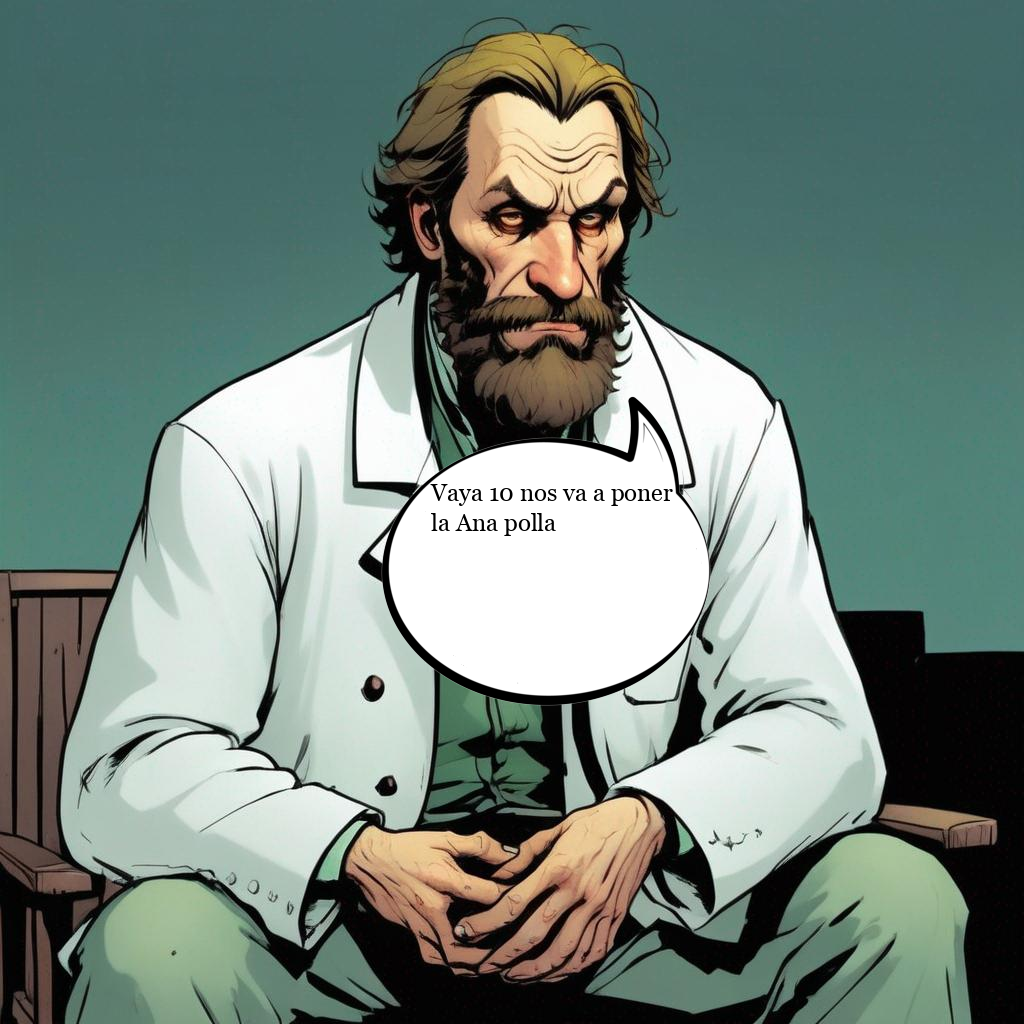

In [ ]:
image_with_bubble